In [3]:
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf
from helper_functions import setup
from helper_functions.classes.sport_event import SportEvent


In [12]:
df = setup.sanitize_and_anonymize_data(overwrite=True, anonymize=False)

sports = {sport: len(df[df[sport]]) for sport in hf.DATA_NOW.sport_events}
sports = sorted(sports.items(), key=lambda x: x[1], reverse=True)
print(f"{len(df)} entries with the following distribution:\n\t{df["status"].value_counts().to_dict()}\n\t{df["institute"].value_counts().to_dict()}\n\t{sports}")

# print(",\n".join(df["nickname"].tolist()))

endings = [email.split("@")[1] if email != "???" else email for email in df["email"]]
print(len([end for end in endings if end == "???"]), "unknown email-addresses.")
# df.sort_values("num_sports", ascending=False)[["name", "num_sports"]].head(3)
# df["events_interested_in"].iloc[1]
# df[["volleyball", "ping_pong", "ping_pong_days"]]


[sports_week: WARNING] - Could not find the following people that payment was received from. Please check their names: ['AsMa', 'ViGo', 'MaRe']
18 entries with the following distribution:
	{'PhD': 15, 'PostDoc': 3}
	{'MPE': 5, 'IPP': 5, 'USM/LMU': 4, 'ESO': 2, 'MPA': 2}
	[('ping_pong', 13), ('volleyball', 9), ('spikeball', 8), ('football', 7), ('capture_the_flag', 7), ('foosball', 7), ('basketball', 5), ('chess', 4), ('tennis', 3), ('badminton', 3), ('beer_pong', 3), ('running_sprints', 1)]
0 unknown email-addresses.


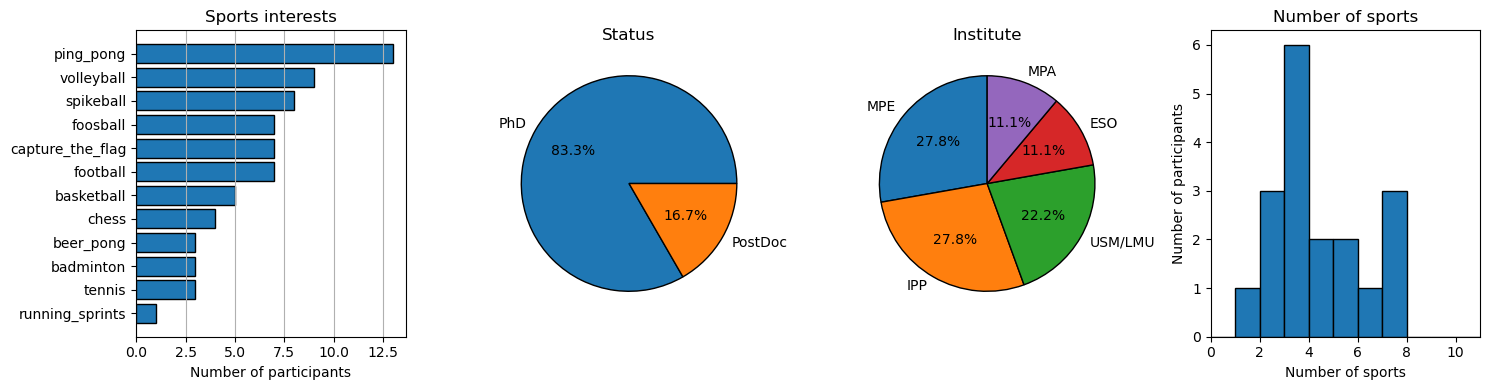

In [11]:
import pandas as pd
from matplotlib.axes import Axes
def _plot_sports_num(df: pd.DataFrame, ax: Axes):
    ax.hist(df["num_sports"], bins=np.arange(0, 12, 1), edgecolor="black")
    ax.set_title("Number of sports")
    ax.set_xlabel("Number of sports")
    ax.set_ylabel("Number of participants")
    ax.set_xlim(0, 11)

def _plot_status_distribution(df: pd.DataFrame, ax: Axes):
    ax.pie(df["status"].value_counts().values, labels=df["status"].value_counts().index, autopct="%1.1f%%", wedgeprops=dict(edgecolor="black"))
    ax.set_title("Status")

def _plot_institute_distribution(df: pd.DataFrame, ax: Axes):
    ax.pie(df["institute"].value_counts().values, labels=df["institute"].value_counts().index, autopct="%1.1f%%", wedgeprops=dict(edgecolor="black"), startangle=90)
    ax.set_title("Institute")

def _plot_sports_interests(df: pd.DataFrame, ax: Axes):
    sports = {sport: len(df[df[sport]]) for sport in hf.DATA_NOW.sport_events}
    sports = sorted(sports.items(), key=lambda x: x[1], reverse=False)
    ax.barh([sport[0] for sport in sports], [sport[1] for sport in sports], edgecolor="black")
    ax.set_title("Sports interests")
    # ax.set_label("Sport")
    ax.set_xlabel("Number of participants")
    ax.grid(axis="x")
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

_plot_sports_interests(df, axes[0])
_plot_status_distribution(df, axes[1])
_plot_institute_distribution(df, axes[2])
_plot_sports_num(df, axes[3])
fig.tight_layout()


In [7]:
df["events_interested_in"].iloc[2]


'Volleyball - Monday 5th of May;Football  -  Tuesday 6th of May;Tennis - Tuesday 6th of May;Spikeball - Wednesday 7th of May;Capture the flag - Thursday 8th of May;Fooseball - Friday 9th of May;Ping Pong - Monday 5th of May (see note above);Ping Pong - Tuesday 6th of May;Ping Pong - Wednesday 7th of May;Ping Pong - Thursday 8th of May;Ping Pong - Friday 9th of May'